# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit,njit,float64,int32

# Parameters

In [3]:
tiempo_vida_inicial = 0
tiempo_vida_maximo = 150            #Para que los resultados obtenidos se encuentren ligados a realidad biologica
pasos_integracion = 150             #Definicion de los pasos de integracion de algoritmo   #Tasa de propagacion de daño
coupling_factor = 0.089             #Factor de acoplamiento entre frailty index y gompertz
mortality_rate = 4.3*(10**(-2.3))     #Tasa de mortalidad

# Functions

In [4]:
def f(x, alpha_damage_propagation, disease_rate, t=None):
    return (1-x)*(alpha_damage_propagation*x + disease_rate)

In [5]:
def Runke_Kutta_Method(temporal_evolution:list, disease_rate):
    x = 0.1                                         #Initial condition     
    frailty_index = np.empty((len(temporal_evolution)))
    for index, t in enumerate(temporal_evolution):
        frailty_index[index] = x
        k1 = h*f(x, alpha_damage_propagation, disease_rate, t=t)
        k2 = h*f(x+0.5*k1, alpha_damage_propagation, disease_rate, t=t +0.5*h)
        x += k2

    gompertz_law = mortality_rate*(frailty_index**(coupling_factor/alpha_damage_propagation))
    return frailty_index, gompertz_law, temporal_evolution

# Gillespie

In [6]:
@njit()
def Gillespie(trp0,tmax, N_total, disease_rate):
    """
    Esta funcion se emplea solamente para hacer la evolución de un paso individual en la celula. Evoluciona no un paso temporal, 
    pero si temporalmente la cantidad de veces que pueda evolucionar antes del tmax en una corrida
    """
    t,N, died =trp0 

    while t < tmax and not died :
        s_1 =  ((N_total-N)/(N_total))*(alpha_damage_propagation*N + disease_rate*N_total)
        s_2 = mortality_rate*((N/N_total)**(coupling_factor/alpha_damage_propagation))
        S_T = s_1 + s_2 

        τ = (-1/S_T)*np.log(np.random.rand())
        x = np.random.rand()

        if x <= (s_1)/S_T:
            N += 1
        else: 
            died = True
            break
        t+=τ
    return np.array([t,N, died]) 
@njit()
def Estado_celula(X0,tiempos, N_total, disease_rate):
    
    X = np.empty((len(tiempos),len(X0)))
    X[:] = np.nan
    X[0] = X0
    
    for i in range(1,len(tiempos)):
        X[i] = Gillespie(X[i-1],tiempos[i], N_total, disease_rate)
        if X[i][2]:
            break
    return X

# Phenomenological Data

In [337]:
import csv
phenomenological_age = []
phenomenological_frailty_index = []
with open("Phenomenological_data.csv", 'r') as file:
  csvreader = csv.reader(file, delimiter=",")
  for fila in csvreader:
    phenomenological_age.append(float(fila[0]))
    phenomenological_frailty_index.append(float(fila[1]))

In [338]:
import csv
frailty_index_data_age = []
frailty_index_data_index = []
with open("frailty_index_data_GNM.csv", 'r') as file:
  csvreader = csv.reader(file, delimiter=",")
  for fila in csvreader:
    frailty_index_data_age.append(float(fila[0]))
    frailty_index_data_index.append(float(fila[1]))

In [7]:
N_total_steps = [300]
disease_rate_steps = [0.0000001, 0.001, 0.001*2, 0.001*4, 0.001*8, 0.001*16, 0.001*32, 0.001*64]
simulaciones = np.empty((len(N_total_steps),len(disease_rate_steps)), dtype=object)

alpha_damage_propagation = 0.05
condicion_inicial = 0.02
for idx_D, D in enumerate(tqdm(disease_rate_steps)):
    for idx_N, N in enumerate(tqdm(N_total_steps)):
        x0 = np.array([20., int(300*condicion_inicial), False])    #Condicion Inicial
        num_cel = 5*(10**5) #Cantidad de personas que se estan simulando
        celulas = np.array([Estado_celula(x0,np.arange(0.,tiempo_vida_maximo,1.), N,D ) for i in range(num_cel)])
        simulaciones[idx_N][idx_D] = celulas

 50%|█████     | 4/8 [02:45<02:42, 40.70s/it]

: 

: 

In [340]:
curva_promedio_stochastic_model_1 = np.zeros((len(simulaciones[0][0][0])))
curva_promedio_stochastic_model_2 = np.zeros((len(simulaciones[0][1][0])))
curva_promedio_stochastic_model_3 = np.zeros((len(simulaciones[0][2][0])))
curva_promedio_stochastic_model_4 = np.zeros((len(simulaciones[0][3][0])))
curva_promedio_stochastic_model_5 = np.zeros((len(simulaciones[0][2][0])))
curva_promedio_stochastic_model_6 = np.zeros((len(simulaciones[0][3][0])))

for i in tqdm(np.arange((len(simulaciones[0][0][0])))):
    promedio1 = np.nanmean(simulaciones[0][0][:,i,1])/N_total_steps[0]
    promedio2 = np.nanmean(simulaciones[0][1][:,i,1])/N_total_steps[0]
    promedio3 = np.nanmean(simulaciones[0][2][:,i,1])/N_total_steps[0]
    promedio4 = np.nanmean(simulaciones[0][3][:,i,1])/N_total_steps[0]
    promedio5 = np.nanmean(simulaciones[0][4][:,i,1])/N_total_steps[0]
    promedio6 = np.nanmean(simulaciones[0][5][:,i,1])/N_total_steps[0]

    curva_promedio_stochastic_model_1[i] = promedio1
    curva_promedio_stochastic_model_2[i] = promedio2
    curva_promedio_stochastic_model_3[i] = promedio3
    curva_promedio_stochastic_model_4[i] = promedio4
    curva_promedio_stochastic_model_5[i] = promedio5
    curva_promedio_stochastic_model_6[i] = promedio6

 27%|██▋       | 40/150 [00:52<02:24,  1.31s/it]/var/folders/b8/c7tcpgms33l8z7x93t10121w0000gn/T/ipykernel_19539/3676415773.py:14: RuntimeWarning: Mean of empty slice
  promedio6 = np.nanmean(simulaciones[0][5][:,i,1])/N_total_steps[0]
100%|██████████| 150/150 [03:21<00:00,  1.34s/it]


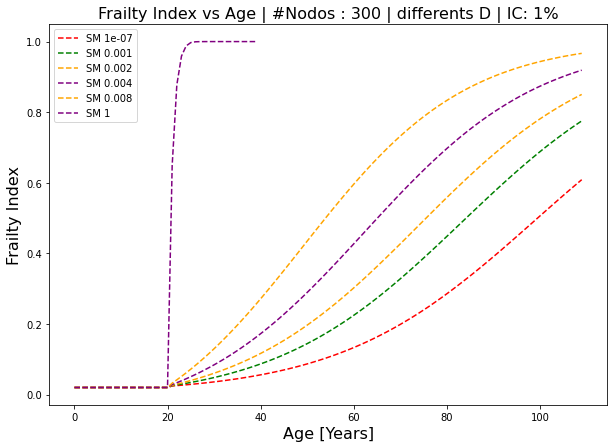

In [343]:
plt.figure(figsize = (10,7))
plt.title(rf"Frailty Index vs Age | #Nodos : {N_total_steps[0]} | differents D | IC: 1%" , fontsize =16)
#plt.scatter(phenomenological_age, phenomenological_frailty_index, color = "black", label = "observacional")
#plt.plot(frailty_index_data_age, frailty_index_data_index, label = "model GNM")

plt.plot(curva_promedio_stochastic_model_1[0:110], label = f"SM {disease_rate_steps[0]}", linestyle = "--", color = "red")
plt.plot(curva_promedio_stochastic_model_2[0:110], label = f"SM {disease_rate_steps[1]}", linestyle = "--", color = "green")
plt.plot(curva_promedio_stochastic_model_3[0:110], label = f"SM {disease_rate_steps[2]}", linestyle = "--", color = "orange")
plt.plot(curva_promedio_stochastic_model_4[0:110], label = f"SM {disease_rate_steps[3]}", linestyle = "--", color = "purple")
plt.plot(curva_promedio_stochastic_model_5[0:110], label = f"SM {disease_rate_steps[4]}", linestyle = "--", color = "orange")
plt.plot(curva_promedio_stochastic_model_6[0:110], label = f"SM {disease_rate_steps[5]}", linestyle = "--", color = "purple")

plt.xlabel(r"Age [Years]", fontsize =16)
plt.ylabel(r"Frailty Index", fontsize =16)
plt.legend()
plt.savefig("Frailty_index_comportamiento_diferente_D_10_porciento_caso_limites_correcion.jpg", dpi = 500)

# Comparison ODEs

In [230]:
tiempo_vida_inicial = 20
tiempo_vida_maximo = 150            #Para que los resultados obtenidos se encuentren ligados a realidad biologica
pasos_integracion = 150             #Definicion de los pasos de integracion de algoritmo   #Tasa de propagacion de daño
coupling_factor = 0.089             #Factor de acoplamiento entre frailty index y gompertz
mortality_rate = 4.3*(10**(-2.3))     #Tasa de mortalidad

In [309]:
def f(x, alpha_damage_factor, disease_rate, t=None):
    return (1-x)*(alpha_damage_factor*x + disease_rate)

def Runke_Kutta_Method_initial_condition(temporal_evolution:list, disease_rate, initial_condition_ODEs, alpha_damage_factor):
    x = initial_condition_ODEs                                        #Initial condition     
    frailty_index = np.empty((len(temporal_evolution)))
    for index, t in enumerate(temporal_evolution):
        frailty_index[index] = x
        k1 = h*f(x, alpha_damage_factor, disease_rate, t=t)
        k2 = h*f(x+0.5*k1, alpha_damage_factor, disease_rate, t=t +0.5*h)
        x += k2

    #gompertz_law = mortality_rate*(frailty_index**(coupling_factor/alpha_damage_factor))
    return frailty_index, frailty_index, temporal_evolution

Valor epsilon: 0.001
Valor gamma: 1.0
Internal/External : 50.0


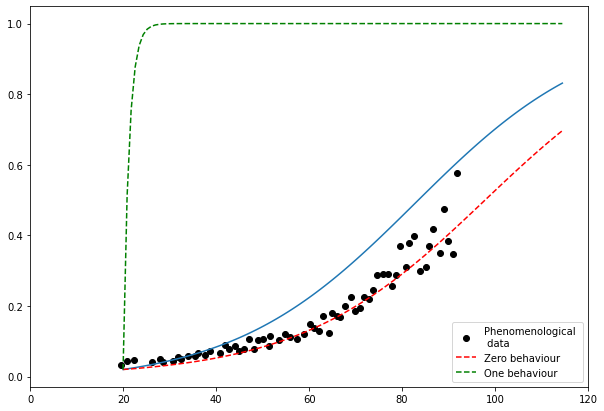

In [335]:
h = (tiempo_vida_maximo-tiempo_vida_inicial)/pasos_integracion                                         #Pasos de integracion
temporal_evolution = np.arange(tiempo_vida_inicial,tiempo_vida_maximo,h) 

alpha_damage_propagation = 0.05
condicion_inicial = 0.02

disease_rate =  0.001

print(f"Valor epsilon: {condicion_inicial*alpha_damage_propagation}")
print(f"Valor gamma: {condicion_inicial*alpha_damage_propagation/disease_rate}")
print(f"Internal/External : {alpha_damage_propagation/disease_rate}")

frailty_index_differential_equation,gompertz_law_differential_equation,temporal_evolution_differential_equation = Runke_Kutta_Method_initial_condition(temporal_evolution, disease_rate, condicion_inicial, alpha_damage_propagation)
frailty_index_differential_equation_cero_reference,gompertz_law_differential_equation,temporal_evolution_differential_equation = Runke_Kutta_Method_initial_condition(temporal_evolution, 0, condicion_inicial, alpha_damage_propagation)
frailty_index_differential_equation_one_reference,gompertz_law_differential_equation,temporal_evolution_differential_equation = Runke_Kutta_Method_initial_condition(temporal_evolution, 1, condicion_inicial, alpha_damage_propagation)

plt.figure(figsize=(10,7))
plt.scatter(phenomenological_age, phenomenological_frailty_index, color = "black", label = "Phenomenological \n data")
plt.xlim(0,120)
plt.plot(temporal_evolution_differential_equation[0:110], frailty_index_differential_equation[0:110])
plt.plot(temporal_evolution_differential_equation[0:110], frailty_index_differential_equation_cero_reference[0:110], label = "Zero behaviour", color = "red", linestyle = "--")
plt.plot(temporal_evolution_differential_equation[0:110], frailty_index_differential_equation_one_reference[0:110], label = "One behaviour", color = "green", linestyle = "--")

plt.legend()

# Distribucion Edades de Muerte

In [ ]:
muertes = np.empty((len(simulaciones), len(simulaciones[0])), dtype = object)
for i in range(len(muertes)):
    for j in range(len(muertes[0])):
        listado = []
        suma = 0
        for k in range(150):
            listado.append(suma)
            muertos = (np.nansum(simulaciones[i][j][:,k,2]))
            suma = muertos
        muertes[i][j] = np.array(listado)/num_cel


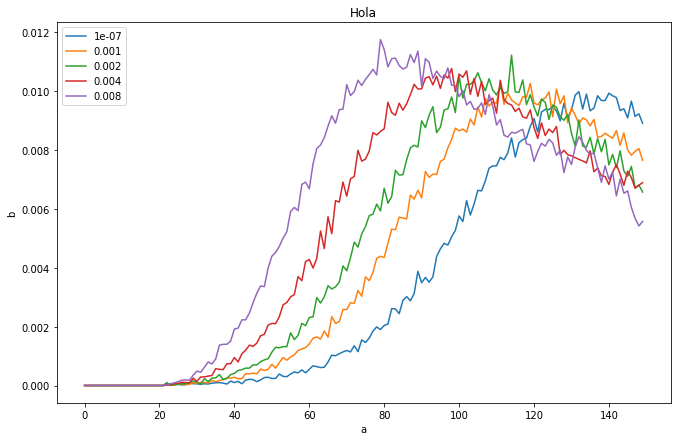

In [ ]:
disease_rate_steps = [0.0000001, 0.001, 0.001*2, 0.001*4, 0.001*8]

plt.figure(figsize=(11,7))
plt.plot(range(150), muertes[0][0], label = rf"{disease_rate_steps[0]}")
plt.plot(range(150), muertes[0][1], label = rf"{disease_rate_steps[1]}")
plt.plot(range(150), muertes[0][2], label = rf"{disease_rate_steps[2]}")
plt.plot(range(150), muertes[0][3], label = rf"{disease_rate_steps[3]}")
plt.plot(range(150), muertes[0][4], label = rf"{disease_rate_steps[4]}")

plt.title("Hola")
plt.xlabel("a")
plt.ylabel("b")
plt.legend()